## Dependents

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib import lines
import os, glob
import cPickle as pickle

home=os.getcwd()
import VM
import YF.hill.main as Hill

path='/Users/yj/repo/vpsc/vpsc-dev-fld/'
os.chdir(path)
import fld,fld_pp
reload(fld);reload(fld_pp)
path='/Users/yj/repo/vpsc/vpsc-dev-yld/src/py_pack/yld_hah/'
os.chdir(path)
import lib_dat

path='/Users/yj/repo/FLD_DIC_XRAY/tutorials/WorkContoursCalc/'
os.chdir(path)
import calc_normal;reload(calc_normal)
os.chdir(home)

from glob import glob
import time
from MP import progress_bar, lib
from MP.lib import mpl_lib
import matplotlib as mpl
from MP.mat import mech
from MP.mat import subtract_elast as se

import scipy as sp
from scipy import integrate
from scipy import optimize
cf=optimize.curve_fit

intp=np.interp#  ## (x,xp,fp,left=None, right=None)
cumtrapz=sp.integrate.cumtrapz

fc=mech.FlowCurve
uet=progress_bar.update_elapsed_time
GS=mpl.gridspec.GridSpec
path_home = os.getcwd()
os.chdir('/Users/yj/repo/vpsc/vpsc-dev-fld')
import fld_pp, fld
from fld_pp import draw_guide

os.chdir('/Users/yj/repo/vpsc/vpsc-dev-yld/src/py_pack/yld_hah/')
import lib_dat
os.chdir(path_home)

def func_voce2(e,a=223,b0=236,b1=1148,c=1540):
    return a-b0*np.exp(-c*e)+b1*e
def lin0(e,a):
    return a*e
def lin1(e,a,a0):
    return a*e+a0
#def func_power(e,a=6.37,n=2.61):
def func_power(e,a,n):
    return a * e**n
def func_voce(e,s0=417,s1=119,ev_inv=15):
    return s0-(s0-s1)*np.exp(-ev_inv*e)
def func_swift(e,c=630,e0=-7.e-5,n=0.256):
    return c*(e+e0)**n

## Necessary functions

In [3]:
def Fit_Err(func,x,popt,sigma):
    values = np.array([
    func(x, popt[0] + sigma[0], popt[1] + sigma[1], popt[2] + sigma[2],popt[3] + sigma[3]),
        
    func(x, popt[0] - sigma[0], popt[1] + sigma[1], popt[2] + sigma[2],popt[3] + sigma[3]),
    func(x, popt[0] + sigma[0], popt[1] - sigma[1], popt[2] + sigma[2],popt[3] + sigma[3]),   
    func(x, popt[0] + sigma[0], popt[1] + sigma[1], popt[2] - sigma[2],popt[3] + sigma[3]),
    func(x, popt[0] + sigma[0], popt[1] + sigma[1], popt[2] + sigma[2],popt[3] - sigma[3]),
        
    func(x, popt[0] - sigma[0], popt[1] - sigma[1], popt[2] + sigma[2],popt[3] + sigma[3]),
    func(x, popt[0] - sigma[0], popt[1] + sigma[1], popt[2] - sigma[2],popt[3] + sigma[3]),
    func(x, popt[0] - sigma[0], popt[1] + sigma[1], popt[2] + sigma[2],popt[3] - sigma[3]),
        
    func(x, popt[0] + sigma[0], popt[1] - sigma[1], popt[2] - sigma[2],popt[3] + sigma[3]),
    func(x, popt[0] + sigma[0], popt[1] - sigma[1], popt[2] + sigma[2],popt[3] - sigma[3]),
    func(x, popt[0] + sigma[0], popt[1] + sigma[1], popt[2] - sigma[2],popt[3] - sigma[3]),        

    func(x, popt[0] - sigma[0], popt[1] - sigma[1], popt[2] - sigma[2],popt[3] + sigma[3]),  
    func(x, popt[0] - sigma[0], popt[1] - sigma[1], popt[2] + sigma[2],popt[3] - sigma[3]),
    func(x, popt[0] - sigma[0], popt[1] + sigma[1], popt[2] - sigma[2],popt[3] - sigma[3]),
    func(x, popt[0] + sigma[0], popt[1] - sigma[1], popt[2] - sigma[2],popt[3] - sigma[3]),
        
    func(x, popt[0] - sigma[0], popt[1] - sigma[1], popt[2] - sigma[2],popt[3] - sigma[3]),
    ])
    return np.std(values, axis=0)

In [4]:
def read_PF(fn):
    """
    Arguments
    ---------
    fn
    """
    dat=np.loadtxt(fn,skiprows=1).T
    # ref, Sx,Sxe,Sy,Sye,Ex,Ey,Exe,Eye = dat    
    return dat    

def filt(d,evm_mx):
    ## ---
    ref=d[:,0] ## using Exx as reference
    ind=np.argsort(ref)
    dm = d[ind,:].T
    ex = dm[5];  ey = dm[6];  ez = -ex-ey

    evm = np.sqrt(2./3.*(ex**2+ey**2+ez**2))
    ##
    sx=dm[1];  sy=dm[3]
    sz=np.zeros((len(sx),))
    p = (sx+sy+sz)/3.
    svm = np.sqrt(3./2.*((sx-p)**2+(sy-p)**2+(ez-p)**2))    
    exr=dm[7];eyr=dm[8]; sxr=dm[2];syr=dm[4]
    xerr=np.sqrt(2./3.*(exr**2+eyr**2))
    yerr=np.sqrt(3./2.*(sxr**2+syr**2))    
    flt = evm<evm_mx
    ex  = ex[flt];    ey  = ey[flt];    ez  = ez[flt]
    sx  = sx[flt];    sy  = sy[flt];    evm = evm[flt];    svm = svm[flt]    
    exr = exr[flt];    eyr = eyr[flt];    sxr = sxr[flt];    syr = syr[flt]
    return evm, svm, ex,ey,exr,eyr, sx,sy,sxr,syr

-- Load bulge experiment for comparison

In [5]:
## Load Pickled bulge data
f=open('../../pickles/IFsteel/bulge_exp','rb')
bulge_exp_dat=pickle.load(f)
f.close()

## Combine BB data and writh the sorted data to PF_raw_dat.txt

In [6]:
def main(dat_master,lab='BB',fig=None,c='r',intp=False,iref=0):
    dat_master=np.array(dat_master)
    # print dat_master.shape

    #1.
    ref=dat_master[:,iref] ## using Exx as reference
    ind=np.argsort(ref)
    dm=dat_master[ind,:].T

    ex=dm[5];ey=dm[6];ez=-ex-ey
    evm = np.sqrt(2./3.*(ex**2+ey**2+ez**2))
    sx=dm[1];sy=dm[3];sz=np.zeros((len(sx),))
    p = (sx+sy+sz)/3.
    svm = np.sqrt(3./2.*((sx-p)**2+(sy-p)**2+(ez-p)**2))

    exr=dm[7];eyr=dm[8]
    sxr=dm[2];syr=dm[4]
    xerr=np.sqrt(2./3.*(exr**2+eyr**2))
    yerr=np.sqrt(3./2.*(sxr**2+syr**2))

    if fig==None:
        fig=plt.figure(figsize=(7,2.2))
        ax1=fig.add_subplot(131);ax2=fig.add_subplot(132);ax3=fig.add_subplot(133)
    else:
        ax1,ax2,ax3=fig.axes
    
    ax1.errorbar(evm,svm,xerr=xerr,yerr=yerr,
                 marker='.',color=c,ls='None',label='Marciniak')
    ax2.errorbar(sx,sy,sxr,sxr,color=c,ls='None')
    ax3.errorbar(ex,ey,exr,exr,color=c,ls='None')

    ax1.set_xlabel(r'$\mathrm{\bar{E}^{VM}}$')
    ax1.set_ylabel(r'$\mathrm{\bar{\Sigma}^{VM}}$  [MPa]')
    ax1.plot(bulge_exp_dat[0],bulge_exp_dat[1],c='k',label='Bulge')
    ax1.set_xlim(0.,0.8)
    #ax1.legend(loc='lower center',fontsize=9)

    for ax in fig.axes:
        lib_dat.tick_bin(ax)

    for i in xrange(len(fig.axes)-1):
        ax=fig.axes[i+1]
        ax.set_xlim(0,)
        ax.set_ylim(0.,)
        ax.set_aspect('equal')
        if i==0: 
            ax.set_xlim(0.,600);ax.set_ylim(0.,600)
            fld_pp.draw_guide(ax,max_r=2,r_line=[0,0.5,1,1.5,2])
        if i==1:
            ax.set_xlim(-0.1,0.5);ax.set_ylim(-0.1,0.5)
            fld_pp.draw_guide(ax,max_r=900,r_line=[-0.5,0,1,2,2.5])
    
    plt.tight_layout()
    fig.savefig('marciniak_bulge_%s.pdf'%lab,bbox_inches='tight')
    return fig

## Application of main

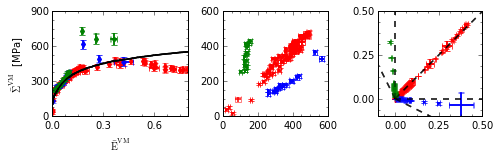

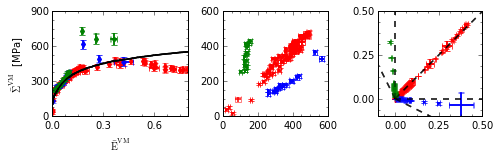

In [7]:
fns_BB=glob('/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/BB/*/PF_raw_dat.txt')
fns_BB.sort()
dat_master_BB=[]
for i in xrange(len(fns_BB)):
    dat = read_PF(fns_BB[i]) # ref, Sx,Sxe,Sy,Sye,Ex,Ey,Exe,Eye
    nstp = dat.shape[1]
    for j in xrange(nstp):
        dat_master_BB.append(dat[:,j])
dat_master_BB=np.array(dat_master_BB)
fig=main(dat_master_BB,'BB',c='r',iref=0)

fns_BB=glob('/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/PS/20120713/PF_raw_dat.txt')
fns_BB.sort()
dat_master_PR=[]
for i in xrange(len(fns_BB)):
    dat = read_PF(fns_BB[i]) # ref, Sx,Sxe,Sy,Sye,Ex,Ey,Exe,Eye
    nstp = dat.shape[1]
    for j in xrange(nstp):
        dat_master_PR.append(dat[:,j])
dat_master_PR=np.array(dat_master_PR)
fig=main(dat_master_PR,'PSRD',fig,c='b',iref=0)

fns_BB=glob('/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/PS/20120717/PF_raw_dat.txt')
fns_BB.sort()
dat_master_PT=[]
for i in xrange(len(fns_BB)):
    dat = read_PF(fns_BB[i]) # ref, Sx,Sxe,Sy,Sye,Ex,Ey,Exe,Eye
    nstp = dat.shape[1]
    for j in xrange(nstp):
        dat_master_PT.append(dat[:,j])
dat_master_PT=np.array(dat_master_PT)
main(dat_master_PT,'PSTD',fig,c='g',iref=1)

- Filter

[  221.9623614    215.57497251  1224.86637701   968.97588782] [  222.05638161   187.40775779  1036.93202357   232.99207492]


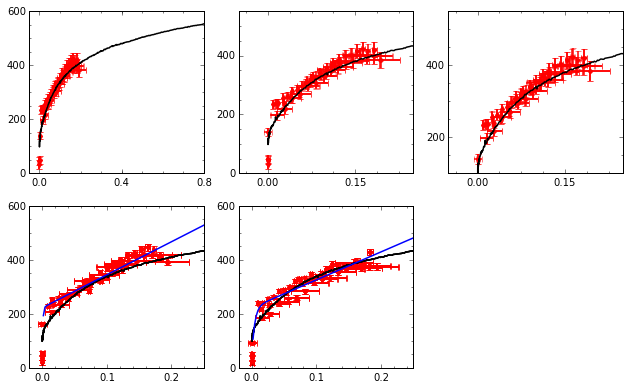

In [8]:
evm_mx = 0.25
evm, svm, ex, ey, exr, eyr, sx, sy, sxr, syr = filt(dat_master_BB,evm_mx)
fig=plt.figure(figsize=(11,6))
ax1=fig.add_subplot(231); ax2=fig.add_subplot(232);ax3=fig.add_subplot(233)
ax4=fig.add_subplot(234); ax5=fig.add_subplot(235)

## strain fit
x_ref = np.linspace(0.002,evm_mx,100)
x=evm; y1=ex; y2=ey
func = lin0
popt1_e,pcov1 = cf(func,x,y1)
popt2_e,pcov2 = cf(func,x,y2)
y1_fit_e, y2_fit_e = func(x_ref,*popt1_e), func(x_ref,*popt2_e)
    
    ## Stress fit
x=evm; y1=sx; y2=sy
func = func_voce2
popt1_s,pcov1 = cf(func,x,y1)
popt2_s,pcov2 = cf(func,x,y2)    
y1_fit_s, y2_fit_s = func(x_ref,*popt1_s), func(x_ref,*popt2_s)  
print popt1_s, popt2_s

ax4.plot(x_ref,y1_fit_s,zorder=150)
ax5.plot(x_ref,y2_fit_s,zorder=150)



for ax in [ax1,ax2,ax3]:
    ax.errorbar(evm,svm,yerr=sxr+syr,xerr=exr+eyr,ls='None',marker='.',color='red')
    ax.plot(bulge_exp_dat[0],bulge_exp_dat[1],'k-',zorder=100)
    ax4.plot(bulge_exp_dat[0],bulge_exp_dat[1],'k-',zorder=100)
    ax5.plot(bulge_exp_dat[0],bulge_exp_dat[1],'k-',zorder=100)
    
    ax4.errorbar(evm,sx,yerr=sxr,xerr=exr+eyr,ls='None',marker='.',color='red')
    ax5.errorbar(evm,sy,yerr=syr,xerr=exr+eyr,ls='None',marker='.',color='red')


evm_intp = np.linspace(0,evm_mx,10)

ax1.set_xlim(-0.05,0.8)
ax4.set_xlim(-0.02,evm_mx)
ax5.set_xlim(-0.02,evm_mx)
ax2.set_xlim(-0.05,evm_mx);ax2.set_ylim(0,550)
ax3.set_xlim(-0.05,evm_mx);ax3.set_ylim(100,550)

lib_dat.tick_bin(ax1)
lib_dat.tick_bin(ax2)
lib_dat.tick_bin(ax3)
lib_dat.tick_bin(ax4)
lib_dat.tick_bin(ax5)

  BB    222.0    215.6   1224.9    969.0   --    222.1    187.4   1036.9    233.0 
PSRD    231.5   6776.3   1913.8   1922.3   --    112.4   7326.7   1072.6   1898.9 
PSTD 

/Users/yj/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/yj/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


   118.1    -22.2    229.3   3117.0   --    201.6    -55.5   2434.9     67.5 


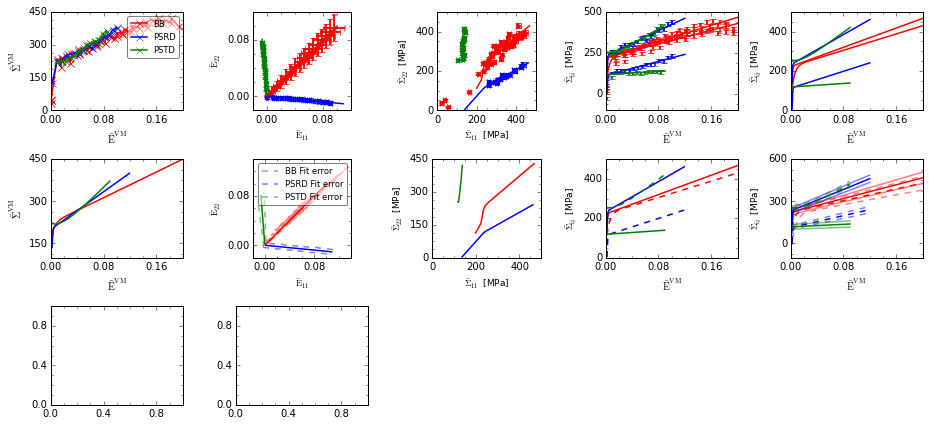

In [9]:
D=[dat_master_BB,dat_master_PR,dat_master_PT]
labs=['BB','PSRD','PSTD']
cs  =['r','b','g']
evm_mx=[0.20,0.12,0.09]

fig=plt.figure(figsize=(13,6))
ax1=fig.add_subplot(351); ax2=fig.add_subplot(352)
ax3=fig.add_subplot(353); ax4=fig.add_subplot(354)
ax5=fig.add_subplot(355); ax6=fig.add_subplot(356)
ax7=fig.add_subplot(357); ax8=fig.add_subplot(358)
ax9=fig.add_subplot(359);ax10=fig.add_subplot(3,5,10)
ax11=fig.add_subplot(3,5,11);ax12=fig.add_subplot(3,5,12)

numpy.seterr(all='raise')             
FCs_XRD=[]

for i in xrange(len(D)):
    d=D[i]
    lab=labs[i]
    emx=evm_mx[i]    
    evm, svm, ex, ey, exr, eyr, sx,sy,sxr,syr = filt(d,emx)

    ## strain fit
    x_ref = np.linspace(0.0022,emx,100)
    x=evm; y1=ex; y2=ey
    func = lin0
    popt1_e,pcov1 = cf(func,x,y1)
    popt2_e,pcov2 = cf(func,x,y2)
    y1_fit_e, y2_fit_e = func(x_ref,*popt1_e), func(x_ref,*popt2_e)
    
    ## Stress fit
    x=evm; y1=sx; y2=sy
    func = func_voce2
    popt1_s,pcov1 = cf(func,x,y1)
    popt2_s,pcov2 = cf(func,x,y2)    
    y1_fit_s, y2_fit_s = func(x_ref,*popt1_s), func(x_ref,*popt2_s)    

    if i!=0:
        ## Interpolate uncertainty    
        ## stress
        sxr_ = np.interp(x_ref,x,sxr)
        syr_ = np.interp(x_ref,x,syr)
    elif i==0: ## BB
        sigma1 = np.sqrt(np.diag(pcov1))
        sigma2 = np.sqrt(np.diag(pcov2))
        sxr_ = Fit_Err(func=func_voce2,x=x_ref,popt=popt1_s,sigma=sigma1)*2
        syr_ = Fit_Err(func=func_voce2,x=x_ref,popt=popt2_s,sigma=sigma2)*2
        ## np.interp(x_ref,)
        
    ## strain
    exr_ = np.interp(x_ref,x,exr)
    eyr_ = np.interp(x_ref,x,eyr)
    print '%4s '%lab,
    for j in xrange(len(popt1_s)):
        print '%7.1f '%popt1_s[j],
    print ' -- ',
    for j in xrange(len(popt2_s)):
        print '%7.1f '%popt2_s[j],
    print

    ## Below is plottings.
    ## Raw data
    l,=ax1.plot(evm,svm,'x-',color=cs[i],label=lab)     
    
    c=l.get_color()    
    ax2.errorbar(ex,ey,exr,eyr,'.',color=c,ls='None')
    ax3.errorbar(sx,sy,sxr,syr,'.',color=c,ls='None')    
    ax4.errorbar(x,y1,yerr=sxr,color=c,ls='None')
    ax4.errorbar(x,y2,yerr=syr,color=c,ls='None')
    
    ## strain fit
    ax2.plot(y1_fit_e,y2_fit_e,color=c)
    ## stress fit
    ax3.plot(y1_fit_s,y2_fit_s,color=c)    

    ## EVM vs. Sij plots
    ax4.plot(x_ref,y1_fit_s,color=c)
    ax4.plot(x_ref,y2_fit_s,color=c)
    ax5.plot(x_ref,y1_fit_s,color=c)
    ax5.plot(x_ref,y2_fit_s,color=c)
    
    ## Uncertainty in stress fits...
    func = func_voce2
    # Stress11
    ax10.plot(x_ref,func(x_ref,*popt1_s),color=c,ls='-')
    ax10.plot(x_ref,func(x_ref,*popt1_s)+sxr_*2,color=c,alpha=0.5,ls='-')
    ax10.plot(x_ref,func(x_ref,*popt1_s)-sxr_*2,color=c,alpha=0.5,ls='-')
    # Stress22
    ax10.plot(x_ref,func(x_ref,*popt2_s),color=c,ls='--')
    ax10.plot(x_ref,func(x_ref,*popt2_s)+syr_*2,color=c,alpha=0.5,ls='--')
    ax10.plot(x_ref,func(x_ref,*popt2_s)-syr_*2,color=c,alpha=0.5,ls='--')

    func = lin0
    # Strain11
    ax7.plot(func(x_ref,*popt1_e)+exr_*2,func(x_ref,*popt2_e)+eyr_*2,
             alpha=0.5,color=c,ls='--',label='%s Fit error'%lab)
    ax7.plot(func(x_ref,*popt1_e)-exr_*2,func(x_ref,*popt2_e)-eyr_*2,
             alpha=0.5,color=c,ls='--')

    
    
    ## raw data
    ex,ey,exr,eyr,sx,sy,sxr,syr
    ## Strain fit
    strain_func=lin0
    x_ref,popt1_e,popt2_e
    ## Stress fit
    stress_func=func_voce2
    x_ref, popt1_s, popt2_s

    ## smoothed arrays.
    FC=fc()
    e11 = strain_func(x_ref,*popt1_e)
    e22 = strain_func(x_ref,*popt2_e)
    e33 = -e11-e22
    
    s11 = stress_func(x_ref,*popt1_s)
    s22 = stress_func(x_ref,*popt2_s)
    
    FC.get_strain(e11,0,0)
    FC.get_strain(e22,1,1)
    FC.get_strain(e33,2,2)
    FC.set_zero_shear_strain()
    FC.get_stress(s11,0,0)
    FC.get_stress(s22,1,1)
    FC.set_zero_sigma_ij(2,2)
    FC.set_zero_shear_stress()
    
    FC.integrate_work()
    FC.get_eqv()
    
    ## Added errors.
    FC.fit_err_stress=[sxr_, syr_]
    FC.fit_err_strain=[exr_, eyr_]
    

    
    
    FCs_XRD.append(FC)
    pass

for i in xrange(len(FCs_XRD)):
    c=cs[i]
    FC=FCs_XRD[i]
    ax6.plot(FC.epsilon_vm,FC.sigma_vm,color=c)
    ax7.plot(FC.epsilon[0,0],FC.epsilon[1,1],color=c)
    ax8.plot(FC.sigma[0,0],FC.sigma[1,1],color=c)
    ax9.plot(FC.epsilon_vm,FC.sigma[0,0],color=c,ls='-')
    ax9.plot(FC.epsilon_vm,FC.sigma[1,1],color=c,ls='--')
    


## Plot decos.
ax5.set_ylim(0.,) 

for ax in [ax1,ax6]:
    ax.set_xlabel(r'$\mathrm{\bar{E}^{VM}}$')
    ax.set_ylabel(r'$\mathrm{\bar{\Sigma}^{VM}}$')

for ax in fig.axes:
    lib_dat.tick_bin(ax)
    ax.legend()
for ax in [ax2,ax7]:
    ax.set_ylabel(r'$\mathrm{\bar{E}_{22}}$',fontsize=9)
    ax.set_xlabel(r'$\mathrm{\bar{E}_{11}}$',fontsize=9)
for ax in [ax3,ax8]:
    ax.set_ylabel(r'$\mathrm{\bar{\Sigma}_{22}}$  [MPa]',fontsize=9)
    ax.set_xlabel(r'$\mathrm{\bar{\Sigma}_{11}}$  [MPa]',fontsize=9)
    ax.set_xlim(0.,); ax.set_ylim(0.,)
for ax in [ax4,ax5,ax10,ax9]:
    ax.set_xlabel(r'$\mathrm{\bar{E}^{VM}}$')
    ax.set_ylabel(r'$\mathrm{\bar{\Sigma}_{ij}}$  [MPa]',fontsize=9)
for ax in fig.axes[1:3]+fig.axes[6:8]:
    ax.set_aspect('equal')
plt.tight_layout()

## Load Uniaxial pickles

In [10]:
fns_uni=glob('../../pickles/IFsteel/FC_raw_U??.pck')
fns_uni.sort()
FC_UNIs=[]
for i in xrange(len(fns_uni)):
    with open(fns_uni[i],'rb') as f:
        FC_UNIs.append(pickle.load(f))
    FC_UNIs[i].integrate_work()

## Calculate work levels corresponding to E^RD
ERD_ref=[0.01,0.05,0.10,0.15,0.20]
FC_RD=FC_UNIs[0]
ERD=FC_RD.epsilon[0,0]

print max(FC_RD.epsilon[0,0])

work_levels = np.interp(ERD_ref,ERD,FC_RD.work)

print work_levels
print work_levels[-1]
norm=mpl.colors.Normalize(0,work_levels[-1]*1.05)
cmap, mc = mpl_lib.norm_cmap(mn=0,mx=work_levels[-1]*1.05,cm_name='brg')

0.236837875469
[  1.49254774   9.98252306  23.57029991  39.04370775  55.81657489]
55.8165748881


## Find interpolates.

In [11]:
with open('../../pickles/IFsteel/vpsc_rho_IF','rb') as f:
    fc_VPSC=pickle.load(f)
for i in xrange(len(fc_VPSC)):
    f=fc_VPSC[i]
    f.integrate_work()
    #plot(f.sigma[0,0],f.sigma[1,1])
    
            
## VPSC
k=0
nrot = len(fc_VPSC)
dat_vpsc=np.zeros((2,len(work_levels),nrot))
for i in xrange(len(work_levels)):
    for j in xrange(nrot):
        _fc_=fc_VPSC[j]
        s11=_fc_.sigma[0,0]
        s22=_fc_.sigma[1,1]
        _fc_.integrate_work()

        _s11_=interp(work_levels[i],_fc_.work,s11)
        _s22_=interp(work_levels[i],_fc_.work,s22)
        dat_vpsc[0,i,j]=_s11_; dat_vpsc[1,i,j]=_s22_

URD
UTD
BB
PSRD
PSTD
170.560096542
244.765723579
293.794402812
323.619820865
346.180316378


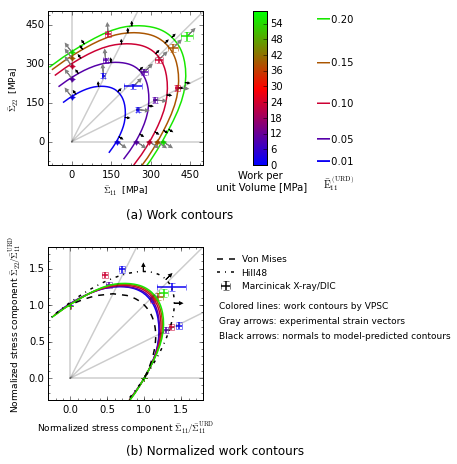

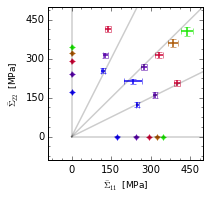

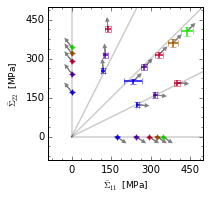

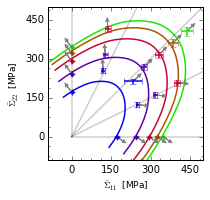

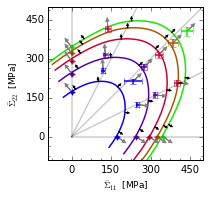

In [12]:
##
fac1=3.5
fac2=fac1/2.5

fig = plt.figure(figsize=(5*fac1,5*3./2.*fac2))
gs  = GS(32,60)
ax1 = fig.add_subplot(gs[0:8,2:12])
axcb= fig.add_subplot(gs[0:8,15:16])
ax2 = fig.add_subplot(gs[0:8,19:20])
ax3 = fig.add_subplot(gs[12:20,2:12])
# ax4 = fig.add_subplot(gs[10:18,2:12])

fig1 = plt.figure(figsize=(5*fac1,5*3./2.*fac2))
fig1.add_subplot(gs[0:8,2:12])
fig2 = plt.figure(figsize=(5*fac1,5*3./2.*fac2))
fig2.add_subplot(gs[0:8,2:12])
fig3 = plt.figure(figsize=(5*fac1,5*3./2.*fac2))
fig3.add_subplot(gs[0:8,2:12])
fig4 = plt.figure(figsize=(5*fac1,5*3./2.*fac2))
fig4.add_subplot(gs[0:8,2:12])


lib_dat.tick_bin(ax4)

##
labs=['URD','UTD','BB','PSRD','PSTD']
FCs=FC_UNIs+FCs_XRD
r=30
dat_mlx=np.zeros((len(FCs),len(work_levels),6))

for i in xrange(len(FCs)):
    _fc_=FCs[i]
    print labs[i]
    if False:
        if i>1:
            ## subtract elastic portion
            e1=_fc_.epsilon[0,0]
            e2=_fc_.epsilon[1,1]
            s1=_fc_.sigma[0,0]
            s2=_fc_.sigma[1,1]
    
            els_1,els_2=se.bi_axial_iso(e1,e2,s1,s2,M=2.e5,nu=0.3)
            if np.isnan(els_1).any(): raise IOError, 'Nan found'
            if np.isnan(els_2).any(): raise IOError, 'Nan found'
            
            ax4.plot(_fc_.epsilon[0,0],e1)
            _fc_.epsilon[0,0]=_fc_.epsilon[0,0]-els_1[:]
            _fc_.epsilon[1,1]=_fc_.epsilon[1,1]-els_2[:]
    
            flt1=_fc_.epsilon[0,0]<0.
            flt2=_fc_.epsilon[1,1]<0.
            for j in xrange(len(flt1)):
                if flt1[j] or flt2[j]:
                    _fc_.epsilon[0,0,j]=0.
                    _fc_.epsilon[1,1,j]=0.
        if i<2:
            for j in xrange(2):
                _fc_.epsilon[j,j] = _fc_.epsilon[j,j] - 1/2.e5*(_fc_.epsilon[j,j])
                flt=_fc_.epsilon[0:2,0:2,:]<0
                _fc_.epsilon[0:2,0:2,:][flt]=0.
    
    _fc_.get_eqv()
    _fc_.integrate_work()
    s11=_fc_.sigma[0,0]
    s22=_fc_.sigma[1,1]
    _s11_=interp(work_levels,_fc_.work,s11,right=np.nan)#,left=np.nan)
    _s22_=interp(work_levels,_fc_.work,s22,right=np.nan)#,left=np.nan)
    
    if i>1:
        s1e = _fc_.fit_err_stress[0]
        s2e = _fc_.fit_err_stress[1]
        _s11_e_=interp(work_levels,_fc_.work,s1e,right=np.nan,left=np.nan)
        _s22_e_=interp(work_levels,_fc_.work,s2e,right=np.nan,left=np.nan)
        exx = _fc_.epsilon[0,0]; eyy = _fc_.epsilon[1,1]
        _exx_ = interp(work_levels,_fc_.work,exx,right=np.nan)#,left=np.nan)
        _eyy_ = interp(work_levels,_fc_.work,eyy,right=np.nan)#,left=np.nan)
        for j in xrange(len(_s11_)):
            v1=_exx_[j]; v2=_eyy_[j]
            mag=np.sqrt(v1**2+v2**2)
            v1=r*v1/mag; v2=r*v2/mag
            ax1.errorbar(_s11_[j],_s22_[j],_s11_e_[j],_s22_e_[j],
                         color=mc.to_rgba(work_levels[j]))
            ax1.arrow(_s11_[j],_s22_[j],v1,v2,color='gray',
                      head_width=12, head_length=12)
            
            fig1.axes[0].errorbar(_s11_[j],_s22_[j],_s11_e_[j],_s22_e_[j],
                         color=mc.to_rgba(work_levels[j]))
            fig2.axes[0].errorbar(_s11_[j],_s22_[j],_s11_e_[j],_s22_e_[j],
                         color=mc.to_rgba(work_levels[j]))
            fig3.axes[0].errorbar(_s11_[j],_s22_[j],_s11_e_[j],_s22_e_[j],
                         color=mc.to_rgba(work_levels[j]))
            fig4.axes[0].errorbar(_s11_[j],_s22_[j],_s11_e_[j],_s22_e_[j],
                         color=mc.to_rgba(work_levels[j]))


            

            fig2.axes[0].arrow(_s11_[j],_s22_[j],v1,v2,color='gray',
                      head_width=12, head_length=12)
            fig3.axes[0].arrow(_s11_[j],_s22_[j],v1,v2,color='gray',
                      head_width=12, head_length=12)
            fig4.axes[0].arrow(_s11_[j],_s22_[j],v1,v2,color='gray',
                      head_width=12, head_length=12)



            
            dat_mlx[i,j,0]=_s11_[j]
            dat_mlx[i,j,1]=_s22_[j]
            dat_mlx[i,j,2]=_s11_e_[j]
            dat_mlx[i,j,3]=_s22_e_[j]
            dat_mlx[i,j,4]=v1
            dat_mlx[i,j,5]=v2

    if i<=1: # RD or TD
        yerr=interp(work_levels,_fc_.work,_fc_.sigma_xx_e)
        xerr=interp(work_levels,_fc_.work,_fc_.sigma_yy_e)
        exx = _fc_.epsilon[0,0]; eyy = _fc_.epsilon[1,1]
        _exx_ = interp(work_levels,_fc_.work,exx,right=np.nan)
        _eyy_ = interp(work_levels,_fc_.work,eyy,right=np.nan)
        for j in xrange(len(_s11_)):
            v1=_exx_[j]; v2=_eyy_[j]
            mag=np.sqrt(v1**2+v2**2)
            v1=r*v1/mag; v2=r*v2/mag
            ax1.errorbar(_s11_[j],_s22_[j],yerr=yerr[j],xerr=xerr[j],
                         color=mc.to_rgba(work_levels[j]),
                         marker='.',ls='None')
            ax1.arrow(_s11_[j],_s22_[j],v1,v2,
                      color='gray',head_width=12, head_length=12)
            
            
            fig1.axes[0].errorbar(_s11_[j],_s22_[j],yerr=yerr[j],xerr=xerr[j],
                         color=mc.to_rgba(work_levels[j]),
                         marker='.',ls='None')
            fig2.axes[0].errorbar(_s11_[j],_s22_[j],yerr=yerr[j],xerr=xerr[j],
                         color=mc.to_rgba(work_levels[j]),
                         marker='.',ls='None')
            fig3.axes[0].errorbar(_s11_[j],_s22_[j],yerr=yerr[j],xerr=xerr[j],
                         color=mc.to_rgba(work_levels[j]),
                         marker='.',ls='None')
            fig4.axes[0].errorbar(_s11_[j],_s22_[j],yerr=yerr[j],xerr=xerr[j],
                         color=mc.to_rgba(work_levels[j]),
                         marker='.',ls='None')

            
            fig2.axes[0].arrow(_s11_[j],_s22_[j],v1,v2,
                      color='gray',head_width=12, head_length=12)
            fig3.axes[0].arrow(_s11_[j],_s22_[j],v1,v2,
                      color='gray',head_width=12, head_length=12)
            fig4.axes[0].arrow(_s11_[j],_s22_[j],v1,v2,
                      color='gray',head_width=12, head_length=12)


        
            
            dat_mlx[i,j,0]=_s11_[j]
            dat_mlx[i,j,1]=_s22_[j]
            dat_mlx[i,j,2]=yerr[j]
            dat_mlx[i,j,3]=xerr[j]
            dat_mlx[i,j,4]=v1
            dat_mlx[i,j,5]=v2

## Find ths from Exp.
ths=[]
v1s,v2s=dat_mlx[:,0,4],dat_mlx[:,0,5]
for i in xrange(len(v1s)):
    v1,v2=v1s[i],v2s[i]
    ths.append(np.arctan2(v2,v1)*180/np.pi)

for i in xrange(len(work_levels)):
    ## VPSC
    _s11_, _s22_= dat_vpsc[0,i,:], dat_vpsc[1,i,:]
    ax1.plot(_s11_,_s22_,color=mc.to_rgba(work_levels[i]),zorder=-1)
    fig3.axes[0].plot(_s11_,_s22_,color=mc.to_rgba(work_levels[i]),zorder=-1)
    fig4.axes[0].plot(_s11_,_s22_,color=mc.to_rgba(work_levels[i]),zorder=-1)
    
    
    ref,ref_y = calc_normal.find_stress(_s11_,_s22_,*[0])
    ref=ref[0]

    #ref = _s11_[3]
    ax3.plot(_s11_/ref,_s22_/ref,color=mc.to_rgba(work_levels[i]))

    ## Experimental
    ref=dat_mlx[0,i,0]
    print ref
    ax3.errorbar(dat_mlx[:,i,0]/ref,dat_mlx[:,i,1]/ref,
                 dat_mlx[:,i,2]/ref,dat_mlx[:,i,3]/ref,
                 color=mc.to_rgba(work_levels[i]),ls='None')

    ## ticks
    xs,ys   = calc_normal.main(locus_xy=(_s11_,_s22_),ths=ths)
    xsn,ysn = calc_normal.main(locus_xy=(_s11_/ref,_s22_/ref),ths=ths)

    r_ = 0.1
    r  = 20
    for j in xrange(len(ths)):
        dx,dy=r/2.*cos(ths[j]*np.pi/180.),r/2.*sin(ths[j]*np.pi/180.)
        x,y = xs[j],ys[j]
        ax1.arrow(x,y,dx,dy,head_width=6, head_length=6)
        fig4.axes[0].arrow(x,y,dx,dy,head_width=6, head_length=6)

        dx,dy=r_/2.*cos(ths[j]*np.pi/180.),r_/2.*sin(ths[j]*np.pi/180.)
        x,y = xsn[j],ysn[j]
        #ax3.arrow(x,y,dx,dy)

    for j in xrange(5):
        v1,v2=dat_mlx[j,i,4:]
        mag=np.sqrt(v1**2+v2**2)
        v1,v2=v1/mag*r_, v2/mag*r_

## VM
x,y=VM.VM_ys(y=1)
x=np.array(x)
y=np.array(y)
flt1=x>=0.
flt2=y>=0.
flt=[]
for i in xrange(len(flt1)):
    if flt1[i] and flt2[i]: 
        flt.append(True)
    else:
        flt.append(False)
flt=np.array(flt)
x=x[flt]; y=y[flt]
ax3.plot(x,y,color='black',ls='--',label='Von Mises')
##
x,y=np.loadtxt('./dat/Hill48.txt',skiprows=1,delimiter=',').T
x=np.array(x)
y=np.array(y)
flt1=x>=-40.
flt2=y>=-40.
flt=[]
for i in xrange(len(flt1)):
    if flt1[i] and flt2[i]: 
        flt.append(True)
    else:
        flt.append(False)
flt=np.array(flt)
x=x[flt]; y=y[flt]
ax3.plot(x,y,color='black',ls='-.',label='Hill48')


ths_hill = [0,45,90]
xs,ys = calc_normal.main(fn='./dat/Hill48.txt',ths=ths_hill)
r_ = 0.07
for j in xrange(len(ths_hill)):
    dx,dy=r_*cos(ths_hill[j]*np.pi/180.),r_*sin(ths_hill[j]*np.pi/180.)
    x,y = xs[j],ys[j]
    ax3.arrow(x,y,dx,dy,color='Black',head_width=0.04, head_length=0.04)

## -- Hill ends.

mpl.colorbar.ColorbarBase(
    axcb,cmap=cmap,#spacing='proportional',
    orientation='vertical',
    norm=norm)
ax3.errorbar(-2,-2,1,1,color='k',label='Marcinicak X-ray/DIC',ls='None',marker='None')
axcb.set_xlabel('Work per \n unit Volume [MPa]')
ax2.set_axis_off()
axcb.text(6.5,-0.11,s=r'$\mathrm{\bar{E}_{11}^{\ (URD)}}$',
          horizontalalignment='center',
              verticalalignment='center')

for i in xrange(len(work_levels)):
    wrk = work_levels[i]
    y = wrk/max(work_levels)
    ax2.arrow(0,y/1.05,1.5,0,color=mc.to_rgba(work_levels[i]),
              head_width=20, head_length=20)
    axcb.text(6.6,y/1.05,s='%5.2f'%ERD_ref[i],horizontalalignment='center',
              verticalalignment='center',
              transform=axcb.transAxes)

ax3.legend(bbox_to_anchor=(1.9,1),frameon=False,fontsize=9)
ax3.text(1.10,0.6,'Colored lines: work contours by VPSC',transform=ax3.transAxes,fontsize=9)
ax1.set_xlim(-90,);  ax1.set_ylim(-90,)

fig1.axes[0].set_xlim(-90,);  fig1.axes[0].set_ylim(-90,)
fig2.axes[0].set_xlim(-90,);  fig2.axes[0].set_ylim(-90,)
fig3.axes[0].set_xlim(-90,);  fig3.axes[0].set_ylim(-90,)
fig4.axes[0].set_xlim(-90,);  fig4.axes[0].set_ylim(-90,)



ax3.set_xlim(-0.3,1.8); ax3.set_ylim(-0.3,1.8)

ax3.arrow(1.2,0.5,0.2,0.2,transform=ax3.transAxes,
          head_width=0.2, head_length=0.2)
ax3.text(1.10,0.50,'Gray arrows: experimental strain vectors',transform=ax3.transAxes,fontsize=9)
ax3.text(1.10,0.4,'Black arrows: normals to model-predicted contours',transform=ax3.transAxes,fontsize=9)

for ax in [ax1,ax3,fig1.axes[0],fig2.axes[0],fig3.axes[0],fig4.axes[0]]:
    ax.set_ylabel(r'$\mathrm{\bar{\Sigma}_{22}}$  [MPa]',fontsize=9)
    ax.set_xlabel(r'$\mathrm{\bar{\Sigma}_{11}}$  [MPa]',fontsize=9)
    lib_dat.tick_bin(ax,5)
    fld_pp.draw_guide(ax,max_r=900,r_line=[0,0.5,1,1.5,2],
                      ls='-',alpha=0.2)

ax3.set_ylabel(r'Normalized stress component $\mathrm{\bar{\Sigma}_{22}}/\bar{\Sigma}_{11}^\mathrm{URD}$',fontsize=9)
ax3.set_xlabel(r'Normalized stress component $\mathrm{\bar{\Sigma}_{11}}/\bar{\Sigma}_{11}^\mathrm{URD}$',fontsize=9)

ax1.text(0.5,-0.35,'(a) Work contours',fontsize=12,transform=ax1.transAxes)
ax3.text(0.5,-0.35,'(b) Normalized work contours',fontsize=12,transform=ax3.transAxes)

fig.savefig('Exp_Wrk_Uncertainty.pdf',bbox_inches='tight')
fig1.savefig('Exp_Wrk_Uncertainty1.pdf',bbox_inches='tight')
fig2.savefig('Exp_Wrk_Uncertainty2.pdf',bbox_inches='tight')
fig3.savefig('Exp_Wrk_Uncertainty3.pdf',bbox_inches='tight')
fig4.savefig('Exp_Wrk_Uncertainty4.pdf',bbox_inches='tight')

In [13]:
r0 =FCs[0].epsilon[1,1][1:]/FCs[0].epsilon[2,2][1:]
r90=FCs[1].epsilon[0,0][1:]/FCs[0].epsilon[2,2][1:]